In [1]:
# https://www.kaggle.com/wordsforthewise/lending-club

In [2]:
# https://github.com/tywmick/loan-risk-neural-network

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [6]:
#!pip install kaggle

     |████████████████████████████████| 59 kB 5.9 MB/s  eta 0:00:01
     |████████████████████████████████| 118 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 121 kB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73274 sha256=39799d3ddc8a19349f83c997736c2d1d7788d9337d95c69a00d37b8125469328
  Stored in directory: /root/.cache/pip/wheels/de/f7/d8/c3902cacb7e62cb611b1ad343d7cc07f42f7eb76ae3a52f3d1
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6767 sha256=1cc49b5941f7408564e368337e421c742f9067ceb93a36e693f21e1575feb933
  Stored in directory: /root/.cache/pip/wheels/48/1b/6f/5c1cfab22eacbe0095fc619786da6571b55253653c71324b5c
  Created wheel for slugify: filename=slugify-0.0.1-py3-none-any.whl size=1908 sha256=68e42eb084e45858c863af46ad8f65370d3215b1e1959e28c2eb9f54d590a6f9
  Stored in directory: /root/.cache/pip/wheels/d4/7b/0d/bd65011a1b442843bb4043e396f727ab0f1e76050355b9156a
Succ

<IPython.core.display.Javascript object>

In [ ]:
# !mkdir /root/.kaggle/
# !echo '{"username":"shantanuo","key":"c90c207ab8d6c445c54f77c5d5dcdedb"}' > /root/.kaggle/kaggle.json
#! kaggle datasets download -d wordsforthewise/lending-club

In [ ]:
#!apt-get install -y zip
#!unzip lending-club.zip

In [20]:
#!ls -lht

total 1.9G
-rw-r--r-- 1 root root 219K Sep 22 07:57 loan-risk-neural-network.ipynb
drwxr-xr-x 2 root root 4.0K Sep 22 07:56 rejected_2007_to_2018q4.csv
drwxr-xr-x 2 root root 4.0K Sep 22 07:55 accepted_2007_to_2018q4.csv
-rw-r--r-- 1 root root 1.3G Sep 22 07:54 lending-club.zip
drwxr-xr-x 3 root root 4.0K Sep 22 07:49 loan_risk_model
-rwxr-xr-x 1 root root  65K Sep 22 07:49 data_transformer.joblib
-rw-r--r-- 1 root root 244M Dec 17  2019 rejected_2007_to_2018Q4.csv.gz
-rw-r--r-- 1 root root 375M Dec 17  2019 accepted_2007_to_2018Q4.csv.gz


<IPython.core.display.Javascript object>

In [23]:
#!gunzip accepted_2007_to_2018Q4.csv.gz

<IPython.core.display.Javascript object>

In [1]:
!ls -lht

total 3.1G
-rw-r--r-- 1 root root 213K Sep 22 08:01 loan-risk-neural-network.ipynb
drwxr-xr-x 2 root root 4.0K Sep 22 07:56 rejected_2007_to_2018q4.csv
drwxr-xr-x 2 root root 4.0K Sep 22 07:55 accepted_2007_to_2018q4.csv
-rw-r--r-- 1 root root 1.3G Sep 22 07:54 lending-club.zip
drwxr-xr-x 3 root root 4.0K Sep 22 07:49 loan_risk_model
-rwxr-xr-x 1 root root  65K Sep 22 07:49 data_transformer.joblib
-rw-r--r-- 1 root root 244M Dec 17  2019 rejected_2007_to_2018Q4.csv.gz
-rw-r--r-- 1 root root 1.6G Dec 17  2019 accepted_2007_to_2018Q4.csv


In [2]:
!head -199999 accepted_2007_to_2018Q4.csv > head.txt

In [3]:
import pandas as pd

loans = pd.read_csv(
    "head.txt",
    low_memory=False,
)

loans.shape

(199998, 151)

In [4]:
dictionary_df = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

# Drop blank rows, strip white space, convert to Python dictionary, fix one key name
dictionary_df.dropna(axis="index", inplace=True)
dictionary_df = dictionary_df.applymap(lambda x: x.strip())
dictionary_df.set_index("LoanStatNew", inplace=True)
dictionary = dictionary_df["Description"].to_dict()
dictionary["verification_status_joint"] = dictionary.pop("verified_status_joint")

# Print in order of dataset columns (which makes more sense than dictionary's order)
for col in loans.columns:
    print(f"•{col}: {dictionary[col]}")

# Hiding the output because it's quite a few lines, but feel free to take a peek by
# clicking the "Output" button

•id: A unique LC assigned ID for the loan listing.
•member_id: A unique LC assigned Id for the borrower member.
•loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
•funded_amnt: The total amount committed to that loan at that point in time.
•funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
•term: The number of payments on the loan. Values are in months and can be either 36 or 60.
•int_rate: Interest Rate on the loan
•installment: The monthly payment owed by the borrower if the loan originates.
•grade: LC assigned loan grade
•sub_grade: LC assigned loan subgrade
•emp_title: The job title supplied by the Borrower when applying for the loan.*
•emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
•home_ownership: The home owner

For the output variable (the fraction of expected return that was recovered), I'll calculated the _expected return_ by multiplying the monthly payment amount (`installment`) by the number of payments on the loan (`term`), and I'll calculate the _amount actually received_ by summing the total principle, interest, late fees, and post-chargeoff gross recovery received (`total_rec_prncp`, `total_rec_int`, `total_rec_late_fee`, `recoveries`) and subtracting any collection fee (`collection_recovery_fee`).

In [5]:
cols_for_output = ["term", "installment", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]

Several other columns contain either irrelevant demographic data or data not created until after a loan is accepted, so those will need to be removed. I'll hold onto `issue_d` (the month and year the loan was funded) for now, though, in case I want to compare variables to the date of the loan.

`emp_title` (the applicant's job title) _does_ seem relevant in the context of a loan, but it may have too many unique values to be useful.

In [6]:
loans["emp_title"].nunique()

66134

Too many unique values indeed. In a future version of this model I could perhaps try to generate a feature from this column by aggregating job titles into categories, but that effort may have a low return on investment, since there are already columns for annual income and length of employment.

Two other interesting columns that I'll also remove are `title` and `desc` ("description"), which are both freeform text entries written by the borrower. These could be fascinating subjects for natural language processing, but that's outside the scope of the current project. Perhaps in the future I could generate additional features from these fields using measures like syntactic complexity, word count, or keyword inclusion.

In [7]:
cols_to_drop = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "int_rate", "grade", "sub_grade", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "policy_code", "hardship_flag", "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]

loans = loans.drop(columns=cols_to_drop)

Before creating the output variable, however, I must take a closer look at `loan_status`, to see if any loans in the dataset are still open.

In [8]:
loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off            35090
Current                22637
Default                    1
Fully Paid            140990
In Grace Period          347
Late (16-30 days)        148
Late (31-120 days)       785
Name: loan_status, dtype: int64

For practical purposes, I'll consider loans with statuses that don't contain "Fully Paid" or "Charged Off" to still be open, so I'll remove those from the dataset. I'll also merge the "credit policy" columns with their matching status.

In [9]:
credit_policy = "Does not meet the credit policy. Status:"
len_credit_policy = len(credit_policy)
remove_credit_policy = (
    lambda status: status[len_credit_policy:]
    if credit_policy in str(status)
    else status
)
loans["loan_status"] = loans["loan_status"].map(remove_credit_policy)

rows_to_drop = loans[
    (loans["loan_status"] != "Charged Off") & (loans["loan_status"] != "Fully Paid")
].index
loans.drop(index=rows_to_drop, inplace=True)

loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off     35090
Fully Paid     140990
Name: loan_status, dtype: int64

Now to create the output variable. I'll start by checking the null counts of the variables involved.

In [10]:
loans[cols_for_output].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176080 entries, 0 to 199997
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   term                     176080 non-null  object 
 1   installment              176080 non-null  float64
 2   total_rec_prncp          176080 non-null  float64
 3   total_rec_int            176080 non-null  float64
 4   total_rec_late_fee       176080 non-null  float64
 5   recoveries               176080 non-null  float64
 6   collection_recovery_fee  176080 non-null  float64
dtypes: float64(6), object(1)
memory usage: 10.7+ MB


Every remaining row has each of these seven variables, but `term`'s data type is `object`, so that needs to be fixed first.

In [11]:
loans.groupby("term")["term"].count()

term
 36 months    134498
 60 months     41582
Name: term, dtype: int64

Ah, so `term` is a categorical feature with two options. I'll treat it as such when I use it as an input to the model, but to calculate the output variable I'll create a numerical column from it.

Also, I need to trim the whitespace from the beginning of those values—that's no good.

In [12]:
onehot_cols = ["term"]

loans["term"] = loans["term"].map(lambda term_str: term_str.strip())

extract_num = lambda term_str: float(term_str[:2])
loans["term_num"] = loans["term"].map(extract_num)
cols_for_output.remove("term")
cols_for_output.append("term_num")

_Now_ I can create the output variable.

In [13]:
received = (
    loans["total_rec_prncp"]
    + loans["total_rec_int"]
    + loans["total_rec_late_fee"]
    + loans["recoveries"]
    - loans["collection_recovery_fee"]
)
expected = loans["installment"] * loans["term_num"]
loans["fraction_recovered"] = received / expected

loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,35090.0,0.430086,0.217469,0.000000,0.251884,0.408614,0.574912,1.020819
Fully Paid,140990.0,0.949098,0.080764,0.525694,0.924567,0.979120,0.999038,12.400963


There is at least one odd outlier on the right in both categories. But also, many of the "fully paid" loans do not quite reach 1. One potential explanation is that when the last payment comes in, the system just flips `loan_status` to "Fully Paid" without adding the payment amount to the system itself, or perhaps simply multiplying `installation` by the `term` number leaves off a few cents in the actual total. If I were performing this analysis for Lending Club themselves, I'd ask them, but this is just a personal project. I'll consider every loan marked "Fully Paid" to have fully recovered the expected return.

For that matter, I'll cap my `fraction_recovered` values for charged off loans at 1.0 as well, since at least one value is above that for some reason.

In [14]:
import numpy as np

loans["fraction_recovered"] = np.where(
    (loans["loan_status"] == "Fully Paid") | (loans["fraction_recovered"] > 1.0),
    1.0,
    loans["fraction_recovered"],
)
loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,35090.0,0.430085,0.217466,0.0,0.251884,0.408614,0.574912,1.0
Fully Paid,140990.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


For the sake of curiosity, I'll plot the distribution of fraction recovered for charged-off loans.

Matplotlib is building the font cache; this may take a moment.


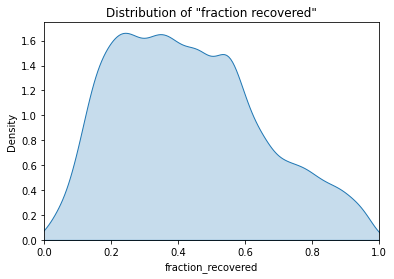

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(
    data=loans["fraction_recovered"][loans["loan_status"] == "Charged Off"],
    label="Charged Off",
    shade=True,
)
plt.axis(xmin=0, xmax=1)
plt.title('Distribution of "fraction recovered"')
plt.show()

Now that the output is formatted, it's time to clean up the inputs. I'll check the null counts of each variable.

In [16]:
loans.drop(columns=cols_for_output, inplace=True)
loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176080 entries, 0 to 199997
Data columns (total 97 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            176080 non-null  float64
 1   term                                 176080 non-null  object 
 2   emp_length                           164946 non-null  object 
 3   home_ownership                       176080 non-null  object 
 4   annual_inc                           176080 non-null  float64
 5   verification_status                  176080 non-null  object 
 6   issue_d                              176080 non-null  object 
 7   loan_status                          176080 non-null  object 
 8   purpose                              176080 non-null  object 
 9   dti                                  176078 non-null  float64
 10  delinq_2yrs                          176080 non-null  float64
 11  earliest_cr_l

Remaining columns with lots of null values seem to fall into three categories:

1. Derogatory/delinquency metrics (where null means the borrower doesn't have any such marks)
  - I'll also add `mths_since_recent_inq` to this list, since its non-null count is below what seems to be the threshold for complete data, which is around 1,277,783. I'll assume a null value here means no recent inquiries.
2. Metrics that only apply to joint applications (where null means it was a single application)
3. An inexplicable series of 14 credit history–related columns that only have around 537,000 entries. Are these newer metrics?

In [17]:
negative_mark_cols = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq", "mths_since_recent_revol_delinq", "sec_app_mths_since_last_major_derog"]
joint_cols = ["annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"]
confusing_cols = ["open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"]

I'll first look at those more confusing columns to find out whether or not they're a newer set of metrics. That'll require converting `issue_d` to date format first.

In [18]:
loans["issue_d"] = loans["issue_d"].astype("datetime64[ns]")

# Check date range of confusing columns
loans[confusing_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                  16436
min      2015-12-01 00:00:00
max      2015-12-01 00:00:00
Name: issue_d, dtype: object

In [19]:
# Compare to all entries from Dec 2015 onward
loans["issue_d"][loans["issue_d"] >= np.datetime64("2015-12-01")].agg(
    ["count", "min", "max"]
)

count                  39002
min      2015-12-01 00:00:00
max      2015-12-01 00:00:00
Name: issue_d, dtype: object

It appears that these are indeed newer metrics, their use only beginning in December 2015, but even after that point usage is spotty. I'm curious to see if these additional metrics would make a model more accurate, though, so once I'm done cleaning the data I'll copy the rows with these new metrics into a new dataset and create another model using the new metrics.

In [20]:
new_metric_cols = confusing_cols

As for the derogatory/delinquency metrics, taking a cue [from Michael Wurm](https://towardsdatascience.com/intelligent-loan-selection-for-peer-to-peer-lending-575dfa2573cb), I'm going to take the inverse of all the "months since recent/last" fields, which will turn each into a proxy for the frequency of the event and also let me set all the null values (when an event has never happened) to 0. For the "months since oldest" fields, I'll just set the null values to 0 and leave the rest untouched.

In [21]:
mths_since_last_cols = [
    col_name
    for col_name in loans.columns
    if "mths_since" in col_name or "mo_sin_rcnt" in col_name
]
mths_since_old_cols = [
    col_name for col_name in loans.columns if "mo_sin_old" in col_name
]

for col_name in mths_since_last_cols:
    loans[col_name] = [
        0.0 if pd.isna(months) else 1 / 1 if months == 0 else 1 / months
        for months in loans[col_name]
    ]
loans.loc[:, mths_since_old_cols].fillna(0, inplace=True)

# Rename inverse columns
rename_mapper = {}
for col_name in mths_since_last_cols:
    rename_mapper[col_name] = col_name.replace("mths_since", "inv_mths_since").replace(
        "mo_sin_rcnt", "inv_mo_sin_rcnt"
    )
loans.rename(columns=rename_mapper, inplace=True)


def replace_list_value(l, old_value, new_value):
    i = l.index(old_value)
    l.pop(i)
    l.insert(i, new_value)


replace_list_value(new_metric_cols, "mths_since_rcnt_il", "inv_mths_since_rcnt_il")
replace_list_value(
    joint_cols,
    "sec_app_mths_since_last_major_derog",
    "sec_app_inv_mths_since_last_major_derog",
)

Now to look closer at joint loans.

In [22]:
loans.groupby("application_type")["application_type"].count()

application_type
Individual    175679
Joint App        401
Name: application_type, dtype: int64

In [23]:
joint_loans = loans[:][loans["application_type"] == "Joint App"]
joint_loans[joint_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 2 to 107224
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   annual_inc_joint                         401 non-null    float64
 1   dti_joint                                400 non-null    float64
 2   verification_status_joint                401 non-null    object 
 3   revol_bal_joint                          0 non-null      float64
 4   sec_app_fico_range_low                   0 non-null      float64
 5   sec_app_fico_range_high                  0 non-null      float64
 6   sec_app_earliest_cr_line                 0 non-null      float64
 7   sec_app_inq_last_6mths                   0 non-null      float64
 8   sec_app_mort_acc                         0 non-null      float64
 9   sec_app_open_acc                         0 non-null      float64
 10  sec_app_revol_util                       0 non-

It seems there may be a case of newer metrics for joint applications as well. I'll investigate.

In [24]:
joint_new_metric_cols = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count      0
min      NaT
max      NaT
Name: issue_d, dtype: object

In [25]:
# Check without `sec_app_revol_util` column
joint_new_metric_cols_2 = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols_2 + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count      0
min      NaT
max      NaT
Name: issue_d, dtype: object

Newer than the previous set of new metrics, even—these didn't start getting used till March 2017. Now I wonder when joint loans were first introduced.

In [26]:
joint_loans["issue_d"].agg(["count", "min", "max"])

count                    401
min      2015-10-01 00:00:00
max      2015-12-01 00:00:00
Name: issue_d, dtype: object

2015\. I think I'll save the newer joint metrics for perhaps a third model, but I believe I can include `annual_inc_joint`, `dti_joint`, and `verification_status_joint` in the main model—I'll just binary-encode `application_type`, and for individual applications I'll set `annual_inc_joint`, `dti_joint`, and `verification_status_joint` equal to their non-joint counterparts.

In [27]:
onehot_cols.append("application_type")

# Fill joint columns in individual applications
for joint_col, indiv_col in zip(
    ["annual_inc_joint", "dti_joint", "verification_status_joint"],
    ["annual_inc", "dti", "verification_status"],
):
    loans[joint_col] = [
        joint_val if app_type == "Joint App" else indiv_val
        for app_type, joint_val, indiv_val in zip(
            loans["application_type"], loans[joint_col], loans[indiv_col]
        )
    ]

loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176080 entries, 0 to 199997
Data columns (total 97 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   loan_amnt                                176080 non-null  float64       
 1   term                                     176080 non-null  object        
 2   emp_length                               164946 non-null  object        
 3   home_ownership                           176080 non-null  object        
 4   annual_inc                               176080 non-null  float64       
 5   verification_status                      176080 non-null  object        
 6   issue_d                                  176080 non-null  datetime64[ns]
 7   loan_status                              176080 non-null  object        
 8   purpose                                  176080 non-null  object        
 9   dti                       

Now the only remaining steps should be removing rows with null values (in columns that aren't new metrics) and encoding categorical features.

I'm _removing_ rows with null values in those columns because that should still leave the vast majority of rows intact, over 1 million, which is still plenty of data. But I guess I should make sure before I overwrite `loans`.

In [28]:
cols_to_search = [
    col for col in loans.columns if col not in new_metric_cols + joint_new_metric_cols
]
loans.dropna(axis="index", subset=cols_to_search).shape

(149833, 97)

Yes, still 1,110,171. That'll do.

In [29]:
loans.dropna(axis="index", subset=cols_to_search, inplace=True)

Then actually I'll tackle `earliest_cr_line` and its joint counterpart first before looking at the categorical features.

In [30]:
loans[["earliest_cr_line", "sec_app_earliest_cr_line"]]

,earliest_cr_line,sec_app_earliest_cr_line
0,Aug-2003,NaN
1,Dec-1999,NaN
2,Aug-2000,NaN
4,Jun-1998,NaN
5,Oct-1987,NaN
...,...,...
199993,Mar-2001,NaN
199994,Jun-1997,NaN
199995,Sep-2003,NaN
199996,Oct-2001,NaN


I should convert that to the age of the credit line at the time of application (or the time of loan issuing, more precisely).

In [31]:
def get_credit_history_age(col_name):
    earliest_cr_line_date = loans[col_name].astype("datetime64[ns]")
    cr_hist_age_delta = loans["issue_d"] - earliest_cr_line_date
    MINUTES_PER_MONTH = int(365.25 / 12 * 24 * 60)
    cr_hist_age_months = cr_hist_age_delta / np.timedelta64(MINUTES_PER_MONTH, "m")
    return cr_hist_age_months.map(
        lambda value: np.nan if pd.isna(value) else round(value)
    )


cr_hist_age_months = get_credit_history_age("earliest_cr_line")
cr_hist_age_months

0         148
1         192
2         184
4         210
5         338
         ... 
199993    173
199994    218
199995    142
199996    165
199997    157
Length: 149833, dtype: int64

In [32]:
loans["earliest_cr_line"] = cr_hist_age_months
loans["sec_app_earliest_cr_line"] = get_credit_history_age(
    "sec_app_earliest_cr_line"
).astype("Int64")
loans.rename(
    columns={
        "earliest_cr_line": "cr_hist_age_mths",
        "sec_app_earliest_cr_line": "sec_app_cr_hist_age_mths",
    },
    inplace=True,
)
replace_list_value(
    joint_new_metric_cols, "sec_app_earliest_cr_line", "sec_app_cr_hist_age_mths"
)

_Now_ a look at those categorical features.

In [33]:
categorical_cols = ["term", "emp_length", "home_ownership", "verification_status", "purpose", "verification_status_joint"]
for i, col_name in enumerate(categorical_cols):
    print(
        loans.groupby(col_name)[col_name].count(),
        "\n" if i < len(categorical_cols) - 1 else "",
    )

term
36 months    112630
60 months     37203
Name: term, dtype: int64 

emp_length
1 year       10681
10+ years    52795
2 years      14227
3 years      12792
4 years       9207
5 years       9559
6 years       6250
7 years       6332
8 years       8204
9 years       6255
< 1 year     13531
Name: emp_length, dtype: int64 

home_ownership
ANY             1
MORTGAGE    73922
OWN         15888
RENT        60022
Name: home_ownership, dtype: int64 

verification_status
Not Verified       38782
Source Verified    69072
Verified           41979
Name: verification_status, dtype: int64 

purpose
car                    1311
credit_card           37492
debt_consolidation    85856
home_improvement       9420
house                   517
major_purchase         2984
medical                1629
moving                  904
other                  7537
renewable_energy         96
small_business         1265
vacation                821
wedding                   1
Name: purpose, dtype: int64 

verification

First, in researching income verification, I learned that LendingClub only tries to [verify income](https://www.lendingclub.com/investing/investor-education/income-verification) on a subset of loan applications based on the content of the application, so this feature is a source of target leakage. I'll remove the two offending columns (and a couple more I don't need anymore).

In [34]:
loans.drop(
    columns=[
        "verification_status",
        "verification_status_joint",
        "issue_d",
        "loan_status",
    ],
    inplace=True,
)

Once I create my pipeline, I'll binary encode `term`, one-hot encode `home_ownership` and `purpose`, and since `emp_length` is an ordinal variable, I'll convert it to the integers 0–10.

In [35]:
onehot_cols += ["home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ]
}

That should cover all the cleaning necessary for the first model's data. I'll save the columns that'll be used in the first model to a new DataFrame, and while I'm at it, I'll start formatting the DataFrames for the two additional models adding the two sets of new metrics.

In [36]:
loans_1 = loans.drop(columns=new_metric_cols + joint_new_metric_cols)
loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149833 entries, 0 to 199997
Data columns (total 80 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amnt                           149833 non-null  float64
 1   term                                149833 non-null  object 
 2   emp_length                          149833 non-null  object 
 3   home_ownership                      149833 non-null  object 
 4   annual_inc                          149833 non-null  float64
 5   purpose                             149833 non-null  object 
 6   dti                                 149833 non-null  float64
 7   delinq_2yrs                         149833 non-null  float64
 8   cr_hist_age_mths                    149833 non-null  int64  
 9   fico_range_low                      149833 non-null  float64
 10  fico_range_high                     149833 non-null  float64
 11  inq_last_6mths            

Before I drop a bunch of rows with nulls from `loans_2`, I'm concerned about `il_util`, as it's missing values in about 50,000 more rows than the rest of the new metric columns. Why would that be?

In [37]:
loans_2["il_util"][loans_2["il_util"].notna()].describe()

count    14706.000000
mean        72.143819
std         22.224998
min          0.000000
25%         59.000000
50%         75.000000
75%         88.000000
max        223.000000
Name: il_util, dtype: float64

Peeking back up to the data dictionary, `il_util` is the "ratio of total current balance to high credit/credit limit on all install acct". The relevant balance (`total_bal_il`) and credit limit (`total_il_high_credit_limit`) metrics appear to already be in the data, so perhaps this utilization metric doesn't contain any new information. I'll compare `il_util` (where it's present) to the ratio of the other two variables.

In [38]:
query_df = loans[["il_util", "total_bal_il", "total_il_high_credit_limit"]].dropna(
    axis="index", subset=["il_util"]
)
query_df["il_util_compute"] = (
    query_df["total_bal_il"] / query_df["total_il_high_credit_limit"]
).map(lambda x: float(round(x * 100)))
query_df[["il_util", "il_util_compute"]]

,il_util,il_util_compute
0,36.0,36.0
1,73.0,73.0
2,73.0,73.0
4,84.0,84.0
5,99.0,99.0
...,...,...
22777,89.0,89.0
22787,87.0,75.0
22794,77.0,77.0
22805,83.0,83.0


In [39]:
(query_df["il_util"] == query_df["il_util_compute"]).describe()

count     14706
unique        2
top        True
freq      11184
dtype: object

In [40]:
query_df["compute_diff"] = abs(query_df["il_util"] - query_df["il_util_compute"])
query_df["compute_diff"][query_df["compute_diff"] != 0].describe()

count    3522.000000
mean       13.743044
std        15.594045
min         1.000000
25%         2.000000
50%         9.000000
75%        19.000000
max       189.000000
Name: compute_diff, dtype: float64

That's weird. `il_util` is equal to the computed ratio three-quarters of the time, but when it's off, the median difference is 10 points off. Perhaps there's new information there sometimes after all. Maybe whatever credit bureau is reporting the utilization rate uses a different formula than just a simple ratio? Again, something I could ask if I were performing this analysis for a client, but that's not the case. I'll assume that this variable is still valuable, and where `il_util` is null I'll impute the value to make it equal to the ratio of `total_bal_il` to `total_il_high_credit_limit` (or 0 if the limit is 0). And I'll add one more boolean field to mark the imputed entries.

Also, that 1,108 is a doozy of an outlier, but I think I'll just leave it be, as it appears that [outliers aren't too big a deal](https://medium.com/analytics-vidhya/effect-of-outliers-on-neural-networks-performance-ca1d9185dce9) if the neural network architecture is sufficiently deep.

In [41]:
loans["il_util_imputed"] = [
    True if pd.isna(util) & pd.notna(bal) & pd.notna(limit) else False
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]
new_metric_onehot_cols = ["il_util_imputed"]
loans["il_util"] = [
    0.0
    if pd.isna(util) & pd.notna(bal) & (limit == 0)
    else float(round(bal / limit * 100))
    if pd.isna(util) & pd.notna(bal) & pd.notna(limit)
    else util
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]

loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149833 entries, 0 to 199997
Data columns (total 81 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amnt                           149833 non-null  float64
 1   term                                149833 non-null  object 
 2   emp_length                          149833 non-null  object 
 3   home_ownership                      149833 non-null  object 
 4   annual_inc                          149833 non-null  float64
 5   purpose                             149833 non-null  object 
 6   dti                                 149833 non-null  float64
 7   delinq_2yrs                         149833 non-null  float64
 8   cr_hist_age_mths                    149833 non-null  int64  
 9   fico_range_low                      149833 non-null  float64
 10  fico_range_high                     149833 non-null  float64
 11  inq_last_6mths            

Good. Ready to drop rows with nulls in `loans_2` and move on to the DataFrame for the model that adds the new metrics for joint applications.

In [42]:
loans_2.dropna(axis="index", inplace=True)

loans_3 = loans.dropna(axis="index")
loans_3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 94 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   loan_amnt                                0 non-null      float64
 1   term                                     0 non-null      object 
 2   emp_length                               0 non-null      object 
 3   home_ownership                           0 non-null      object 
 4   annual_inc                               0 non-null      float64
 5   purpose                                  0 non-null      object 
 6   dti                                      0 non-null      float64
 7   delinq_2yrs                              0 non-null      float64
 8   cr_hist_age_mths                         0 non-null      int64  
 9   fico_range_low                           0 non-null      float64
 10  fico_range_high                          0 non-null      float

Phew, the data's all clean now! Time for the fun part.

## Building the neural networks

After a good deal of trial and error, I found that a network architecture with three hidden layers, each followed by a dropout layer of rate 0.3, was as good as I could find. I used ReLU activation in those hidden layers, and adam optimization and a loss metric of mean squared error in the model as a whole. I tried using mean absolute error at first, but then I found that the resulting model would essentially always guess either 1 or 0 for the output, and the majority of the dataset's output is 1. Therefore, larger errors needed to be penalized to a greater degree, which is what mean squared error is good at.

The dataset being so large, I had great results increasing the batch size for the first couple models.

In [44]:
!pip install sklearn_pandas

  Using cached numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
ERROR: detext 2.0.8 has requirement numpy<1.17, but you'll have numpy 1.19.2 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.6
    Uninstalling numpy-1.16.6:
      Successfully uninstalled numpy-1.16.6


In [45]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout


def run_pipeline(
    data, onehot_cols, ordinal_cols, batch_size, validate=True,
):
    X = data.drop(columns=["fraction_recovered"])
    y = data["fraction_recovered"]
    X_train, X_valid, y_train, y_valid = (
        train_test_split(X, y, test_size=0.2, random_state=0)
        if validate
        else (X, None, y, None)
    )

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    X_train = transformer.fit_transform(X_train)
    X_valid = transformer.transform(X_valid) if validate else None

    input_nodes = X_train.shape[1]
    output_nodes = 1

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3, seed=0))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_squared_error")

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=100,
        validation_data=(X_valid, y_valid) if validate else None,
        verbose=1,
    )

    return history.history, model, transformer


print("Model 1:")
history_1, _, _ = run_pipeline(loans_1, onehot_cols, ordinal_cols, batch_size=128,)
print("\nModel 2:")
history_2, _, _ = run_pipeline(
    loans_2, onehot_cols + new_metric_onehot_cols, ordinal_cols, batch_size=64,
)
print("\nModel 3:")
history_3, _, _ = run_pipeline(
    loans_3, onehot_cols + new_metric_onehot_cols, ordinal_cols, batch_size=32,
)

Model 1:


ValueError: ['term', 'application_type', 'home_ownership', 'purpose']: Found unknown categories ['wedding'] in column 3 during transform

The first model performed best, settling around a mean squared error of 0.0587 (though it seems even after setting `random_state` inside `train_test_split` and `seed` inside the dropout layers, there's still a bit of entropy left in the training of the model, so if you run this notebook yourself, the course of your training may look a little different). Apparently the additional _records_ in the first dataset did more to aid in training than the additional _metrics_ in the subsequent sets. And the dropout layers didn't stop the third model from overfitting anyway.

In [ ]:
sns.lineplot(x=range(1, 101), y=history_1["loss"], label="loss")
sns.lineplot(x=range(1, 101), y=history_1["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.title("Model 1 loss metrics during training")
plt.show()

## Saving the final model

First I need to _create_ the final model, training `model_1`'s architecture on the full dataset. Then I'll save the model to disk with its `save` function and save the data transformer using joblib so I can use it in the API.

In [ ]:
import joblib

_, final_model, final_transformer = run_pipeline(
    loans_1,
    onehot_cols,
    ordinal_cols,
    batch_size=128,
    validate=False,
)

final_model.save("loan_risk_model")
joblib.dump(final_transformer, "data_transformer.joblib")

## Building the API

I first tried building this API and its demonstrational front end on [Glitch](https://glitch.com/), which, officially, only supports Node.js back ends, but unofficially you can get a Python server running there (which I've [done before](https://ty-metricimpconverter-python.glitch.me/ "Python metric-imperial converter microservice – Ty Mick") using [Flask](https://flask.palletsprojects.com/)). When I was almost finished, though, I tried importing TensorFlow to load my model, and it was then that I discovered that unlike Node.js dependencies, Python dependencies get installed to your project's disk space on Glitch, and not even their pro plan provides enough space to contain the entire TensorFlow library. Which totally makes sense—I certainly wasn't using the platform as intended.

Then I discovered [PythonAnywhere](https://www.pythonanywhere.com/)! They have plenty of common Python libraries already installed out-of-the-box, including TensorFlow, so I got everything working perfectly there.

So [head on over](https://tywmick.pythonanywhere.com/ "Neural Network Loan Risk Prediction API – Ty Mick") if you'd like to check it out; the front end includes a form where you can fill in all the parameters for the API request, and there are a couple of buttons that let you fill the form with typical examples from the dataset (since there are a _lot_ of fields to fill in). Or you can send a GET request to `https://tywmick.pythonanywhere.com/api/predict` if you really want to include every parameter in your query string. In either case, you're also more than welcome to take a look at its source [on GitHub](https://github.com/tywmick/loan-risk-neural-network).

-----

One of the best/worst things about machine learning is that your models _always_ have room for improvement. I mentioned a couple ideas along the way above for how I could improve the model in the future, but what's the first thing you would tweak in this model? Feel free to open up an [issue](https://github.com/tywmick/loan-risk-neural-network/issues) or [pull request](https://github.com/tywmick/loan-risk-neural-network/pulls)—I'd love to hear your suggestions!